In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import pandas as pd
import torch.utils.data as data_utils
import matplotlib.pyplot as plt
from collections import deque
import random

In [ ]:
path_to_csv = None #set path to csv location
ratings = pd.read_csv(path_to_csv)
ratings_sorted = ratings.sort_values(by=['timestamp']) #sorting data by by time

In [ ]:
#We now want to split the data into 80%/20% training/testing splits
def split_data(data, split_ratio = 0.8):
    train_size = round(len(data) * split_ratio)
    data_train = data[0:train_size]
    data_test = data[train_size:]
    return data_train, data_test

In [ ]:
#older data for training set, newer data for test set
train_set, test_set = split_data(ratings_sorted)

**Constructing the Adjacancy Matrix**

I will construct two adjacency matrices (one with only training set data filled and other with only test data filled). These will be important when calculating Recall@150 later. I will "zero out" (set ratings to 0) the training set for one adjancy matrix and the test dataset for the other. Below are the implementations.

In [ ]:
test_set_zeroout_rating = test_set.copy()
test_set_zeroout_rating = test_set_zeroout_rating.assign(rating = 0) #zero out the ratings

train_frame = [train_set, test_set_zeroout_rating]
total_data = pd.concat(train_frame) #concatanating the two sets together to form overall adjacency matrix (n_users by n_movies)

#adjacency matrix with test_set data all zeroed out (ratings of test data = 0)
adj_matrix = total_data.pivot(index='userId',columns='movieId',values='rating')
adj_matrix.fillna(0,inplace=True)
#convert all 5 star ratings to a value of 1 and 0 otherwise
adj_matrix[adj_matrix < 5] = 0
adj_matrix[adj_matrix == 5] = 1

#now we create another adjacency matrix with all train_set ratings zeroed out
train_set_zeroout_rating = train_set.copy()
train_set_zeroout_rating = train_set_zeroout_rating.assign(rating = 0)
test_frame = [train_set_zeroout_rating, test_set]
total_data2 = pd.concat(test_frame)

#adjacency matrix with train_set data all zeroed out (ratings of train data = 0)
adj_matrix2 = total_data2.pivot(index='userId',columns='movieId',values='rating')
adj_matrix2.fillna(0,inplace=True)
adj_matrix2[adj_matrix2 < 5] = 0
adj_matrix2[adj_matrix2 == 5] = 1

adj_matrix2

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
607,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
608,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#Create the Direct Embedding Class

In [ ]:
class Direct_Embedding(nn.Module):
  def __init__(self, n_user,n_movie,d, sd):
    super(Direct_Embedding,self).__init__()

    self.embedding_movies = nn.Embedding(n_movie,d)
    nn.init.normal_(self.embedding_movies.weight,std = sd)
    self.embedding_users = nn.Embedding(n_user,d)
    nn.init.normal_(self.embedding_users.weight,std = sd)

    self.embedding_all = nn.Embedding(n_user + n_movie,d)
    nn.init.normal_(self.embedding_all.weight,std = sd)

In [ ]:
#defining dimensions
n_users = adj_matrix.shape[0]
n_movies = adj_matrix.shape[1]
n = n_users + n_movies
d = 10

device = 'cpu'
if torch.cuda.is_available():
  device = 'cuda'

#Recall @150

Side Note: since I already normalized the adjacancy matrices to 0s and 1s, I used torch.nonzero() instead of torch.where(). They both achieve the same goal in the process of calculating recall.

In [ ]:
def recall_atK(dot_product_matrices, adjmatrix, K = 150):
  user_recall_individual = {}
  none_zero_rows = 0
  for i in range(adjmatrix.shape[0]):
    #Calculating Ru
    user_dot_prods = dot_product_matrices[i,:]
    largest150_dot_products_user = torch.topk(user_dot_prods, K)[1] #top 150 largest dot products for one user (Ru), we obtain the position in the row
    #calculating Pu
    actual_rating_user = adjmatrix[i,:]
    positive_tems = actual_rating_user.nonzero(as_tuple = False).reshape(-1) #(obtain position of positive items in current row)
    #calculating size of Pu and size of intersection
    size_Pu = positive_tems.shape[0]
    intersection = np.intersect1d(largest150_dot_products_user,positive_tems) #intersection of Pu and Ru
    size_intersection = len(intersection)

    if size_Pu == 0: #exception handling
      user_recall_individual[i] = 0
      continue

    #recall we have both train and test users in the Adj Matrix, so either one of the two will have 0 ratings for all movies
    #need to keep track of users that actually rated movies when taking average or else many recalls will be 0
    none_zero_rows += 1

    recall_for_user = size_intersection/size_Pu
    user_recall_individual[i] = recall_for_user


    sum_recall = sum(list(user_recall_individual.values()))
    recall_avg_dataset = sum_recall/none_zero_rows#return recall of dataset (divide by number of non-zero users)

  return recall_avg_dataset

#Training Code (Direct)

In [ ]:
def train(model, optimizer_t, l_r, reweighted_adj_matrix, adj_train, adj_test, epochs = 150):
  '''
  Input:

  model: initialized model of class Embedding
  optimizer_t: Type of optimizer to use ("Adam" or "SGD")
  l_r: learning rate
  reweighted_adj_matrix: reweighted adj_matrix with entries equal 200 or -1
  adj_train: adj_matrix containing only the training set data
  adj_test: adj_matrix containing only the test set data
  epochs: number of epochs to train for (default tp 150)

  returns: updated embedding weights
  '''

  if optimizer_t == "SGD":
    optimizer = optim.SGD(model.parameters(), lr=l_r)
  elif optimizer_t == "Adam":
    optimizer = torch.optim.Adam(model.parameters(), lr = l_r)

  optimizer.zero_grad()
  recall_train = np.zeros(epochs) #array to keep track of recall values for train data
  recall_test = np.zeros(epochs) #array to keep track of recall values for test data
  loss_list = np.zeros(epochs) #array to keep track of loss over epochs
  epoch_count = [] #stores epoch number for plotting

  logsigmoid = nn.LogSigmoid()

  for epoch in range(epochs):
    optimizer.zero_grad()
    user_weights = model.embedding_users.weight
    movie_weights = model.embedding_movies.weight
    mat_product = torch.matmul(user_weights, movie_weights.T)

    log_sig_mat_product = logsigmoid(mat_product) #apply sigmoid then log on product
    objective = torch.sum(torch.mul(reweighted_adj_matrix, log_sig_mat_product))
    #note, instead of maximizing objective, we minimize the loss (-1 * objective)
    loss = -1 * objective
    loss.backward()
    optimizer.step()

    #saving loss, recall stats
    epoch_count.append(epoch)
    loss_list[epoch] = loss.item()

    user_weights_updated = model.embedding_users.weight
    movie_weights_updated = model.embedding_movies.weight
    product_updated = torch.matmul(user_weights_updated,movie_weights_updated.T)
    rec_train = recall_atK(product_updated, adj_train) #recall for train data
    rec_test = recall_atK(product_updated, adj_test) #recall for test data

    recall_train[epoch] = rec_train #saving in array
    recall_test[epoch] = rec_test #saving in array

    print("epoch: ", epoch)
    print("Train Recall: ", rec_train)
    print("Test Recall: ", rec_test)

  plt.figure(1)
  plt.plot(epoch_count, loss_list, label = "Loss")
  plt.xlabel("epochs")
  plt.ylabel("loss")
  plt.legend()
  plt.show()

  plt.figure(2)
  plt.plot(epoch_count, recall_train, label = "Recall Train")
  plt.plot(epoch_count, recall_test, label = "Recall Test")
  plt.xlabel("epochs")
  plt.ylabel("Recall")
  plt.legend()
  plt.show()

  return model

**Reweighted matrix:**

The reweighted matrix is required for calculating the objective shown below:




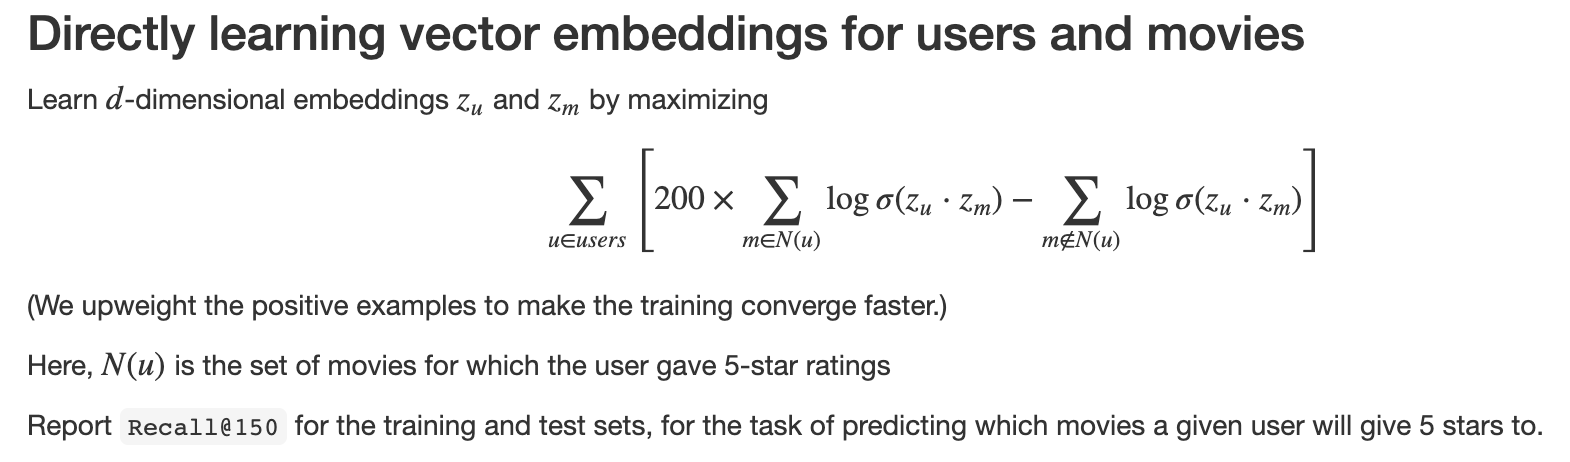

In [ ]:
#initialize embedding
D_mod = Direct_Embedding(n_users,n_movies,10, 0.01)

#create an additional matrix where positive ratings receive weights of 200 and everything else receives weighting -1
reweighted_adj = adj_matrix.copy()
reweighted_adj = torch.from_numpy(reweighted_adj.values).float()

reweighted_adj[reweighted_adj == 0] = -1
reweighted_adj[reweighted_adj == 1] = 200

#convert adj_matrices from df to tensors
adj_train = torch.from_numpy(adj_matrix.values).float()
adj_test = torch.from_numpy(adj_matrix2.values).float()

epoch:  0
Train Recall:  0.061789455174367826
Test Recall:  0.02087513661068415
epoch:  1
Train Recall:  0.1353982238183732
Test Recall:  0.03631366485083208
epoch:  2
Train Recall:  0.22774609241225258
Test Recall:  0.046447309395299445
epoch:  3
Train Recall:  0.3037021481113805
Test Recall:  0.08370126962712592
epoch:  4
Train Recall:  0.363670804997215
Test Recall:  0.11825213041841535
epoch:  5
Train Recall:  0.395117660065328
Test Recall:  0.162092985593892
epoch:  6
Train Recall:  0.4307548754050077
Test Recall:  0.20549219682373435
epoch:  7
Train Recall:  0.44735619386180975
Test Recall:  0.22641899594953943
epoch:  8
Train Recall:  0.46230936697129565
Test Recall:  0.25211050162178367
epoch:  9
Train Recall:  0.463918460927027
Test Recall:  0.26735402852280515
epoch:  10
Train Recall:  0.4676233885353737
Test Recall:  0.2653945572018488
epoch:  11
Train Recall:  0.4698453899347004
Test Recall:  0.2725973921164099
epoch:  12
Train Recall:  0.47555805877615837
Test Recall:  0.2

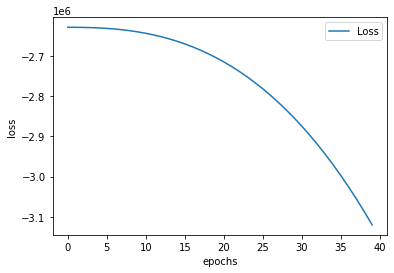

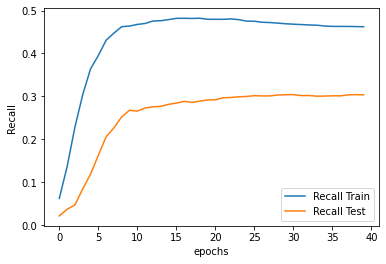

In [ ]:
D_mod2 = Direct_Embedding(n_users,n_movies,10, 0.01)
updated_model2 = train(D_mod2, "Adam", 0.003, reweighted_adj, adj_train, adj_test, epochs = 40)

**Comments:**

After tuning the epoch numbers, learning rates for multiple trials, it was observed that Recall@150 for the training set flattens around 45% and the Recall@150 for the test set flattens aroun 30%. The Adam optimizer was also found to produce more stable results when compared to the SGD optimizer. I am only showing one training run (as multiple outputs can be rather lengthy). Feel feel to run additional training plots by first:

1. Initialize model class: ex:

ex:

`D_mod2 = Direct_Embedding(n_users,n_movies,10, 0.01)`

2. Run train loop:

ex:

`updated_model2 = train(D_mod2, "Adam", 0.003, reweighted_adj, adj_train, adj_test, epochs = 40)`



Optional: Saving Trained Model Weights (Requires Mounting to Drive)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
torch.save(updated_model2.state_dict(), "/content/gdrive/MyDrive/DE2.pth")

#Node2Vec

We will re-split the entire dataset into train/validation/test set (80%/20%/20%)

In [ ]:
def train_val_test_split(data, train_split_at = 0.8, val_split_at = 0.9):
  train_size = round(len(data) * train_split_at)
  val_size = round(len(data) * val_split_at)
  data_train = data[0:train_size]
  data_val = data[train_size:val_size]
  data_test = data[val_size:]

  return data_train, data_val, data_test

In [ ]:
train_set2, val_set2, test_set2 = train_val_test_split(ratings_sorted)

**Stacking 4 Matrices Together**

We will create a bipartite graph by stacking four matrices together. I will use np.bmat():

Ie: we have individual matrices A,B,C,D



```
E = np.bmat([[A,B],[C,D]])

gives us a single matrix E (n by n).

```
\begin{align}
        E = \begin{pmatrix}
        A & B \\
        C & D
        \end{pmatrix}.
    \end{align}

In our case, C is the transpose of B and A and D matrices of zeros. The matrices dimensions are:

A: n_users * n_users

B: n_users * n_movies

C: n_movies * n_users

D: n_movies * n_movies

In [ ]:
#just like with direct embedding, I will zero out the ratings for training, validation and test individually and merge them to create matrix
train_set2_zeroout_rating = train_set2.copy()
train_set2_zeroout_rating = train_set2_zeroout_rating.assign(rating = 0)

val_set2_zeroout_rating = val_set2.copy()
val_set2_zeroout_rating = val_set2_zeroout_rating.assign(rating = 0)

test_set2_zeroout_rating = test_set2.copy()
test_set2_zeroout_rating = test_set2_zeroout_rating.assign(rating = 0)

user_by_user_matrix = np.zeros((n_users, n_users)) #u by u (This is matrix "A")
movies_by_movies_matrix = np.zeros((n_movies, n_movies)) #m by m (matrix "D")

#creating training matrix (val and test zeroed out)
train_frame2 = [train_set2, val_set2_zeroout_rating, test_set2_zeroout_rating]
total_data_train2 = pd.concat(train_frame2)
B = total_data_train2.pivot(index='userId',columns='movieId',values='rating')
B.fillna(0,inplace=True)
B[B < 5] = 0 #replace ratings < 5 with 0
B[B == 5] = 1 #replace 5 star ratings with 1
B = torch.from_numpy(B.values).float() #convert df to tensor

#now we do the "stacking" of 4 matrices to create Bipartite graph
train_matrix2 = np.bmat([[user_by_user_matrix, B], [B.t(), movies_by_movies_matrix]])
train_matrix2 = torch.from_numpy(train_matrix2).float()


#creating validation_matrix (train and test zeroed out)
val_frame2 = [train_set2_zeroout_rating, val_set2, test_set2_zeroout_rating]
total_data_train2 = pd.concat(val_frame2)
B = total_data_train2.pivot(index='userId',columns='movieId',values='rating')
B.fillna(0,inplace=True)
B[B < 5] = 0
B[B == 5] = 1
B = torch.from_numpy(B.values).float()

val_matrix2 = np.bmat([[user_by_user_matrix, B], [B.t(), movies_by_movies_matrix]])
val_matrix2 = torch.from_numpy(val_matrix2).float()

#creating test_matrix (train and val data zeroed out)
test_frame2 = [train_set2_zeroout_rating, val_set2_zeroout_rating, test_set2]
total_data_train2 = pd.concat(test_frame2)
B = total_data_train2.pivot(index='userId',columns='movieId',values='rating')
B.fillna(0,inplace=True)
B[B < 5] = 0
B[B == 5] = 1
B = torch.from_numpy(B.values).float()

test_matrix2 = np.bmat([[user_by_user_matrix, B], [B.t(), movies_by_movies_matrix]])
test_matrix2 = torch.from_numpy(test_matrix2).float()

In [ ]:
#obtain mappings for users and movies
size_graph = torch.from_numpy(np.arange(test_matrix2.shape[0])).float()

unique_users = train_set2['userId'].unique()
train_usersmap = torch.from_numpy(np.arange(len(unique_users))).float()

unique_movies = train_set2['movieId'].unique()
train_moviesmap = torch.from_numpy(np.arange(len(unique_movies))).int()
train_moviesmap = train_moviesmap + n_users #recall in new matrix, we movies index are after users (need to add num_users to obtain movies index)

size_graph = size_graph.int()
train_usersmap = train_usersmap.int()
train_moviesmap = train_moviesmap.int()

#Embedding Class (Node2Vec)

In [ ]:
class NodeEmbedding(nn.Module):
  def __init__(self,n_users,n_movies,d, sd):
    super(NodeEmbedding,self).__init__()
    self.node_embed = nn.Embedding(n_users + n_movies,d)
    nn.init.normal_(self.node_embed.weight, std = sd)

  def forward(self,x):
    x = self.node_embed(x)
    return x

#Recall@K

Acknowledgment: The below code for Recall_at_K is referenced and further modified off the following:
https://github.com/NicolasHug/Surprise/blob/master/examples/precision_recall_at_k.py

In [ ]:
from collections import defaultdict

def Recall_at_K(measures, top_k = 150, threshold = 0.0):
  positive_prediction = defaultdict(list)

  for usr, prediction, rating in measures:
    positive_prediction[usr].append((prediction, rating))

  recalls = {}

  for usr, user_ratings in positive_prediction.items():
    user_ratings.sort(key = lambda x:x[0])
    user_ratings.reverse()

    joint_intersect = 0
    for predict, rating in user_ratings[:top_k]: #calculate intersection
      joint_intersect += ((predict >= threshold) and (rating == 5.0))

    n_rel = 0
    for _, rating in user_ratings: #calculating denominator for recall
      n_rel += (rating == 5.0)

    if n_rel == 0:
      recalls[usr] = 0
      continue

    recalls[usr] = joint_intersect / n_rel

  recall_of_individual_user = list(recalls.values())
  recall_avg_dataset = np.mean(recall_of_individual_user) #return recall of dataset
  return recall_avg_dataset

#Random Walk and Negative Sampling

The following functions are used in the training code. A brief description is provided for better understanding of usage.

**Random_Walk:**

is a function that performs a random walk on an intitial node in graph (b_graph) that is specified by the user. It returns a list of nodes that are explored in the neighbourhood of the initial node.

In [ ]:
def Random_Walk(b_graph,walk_length,initial_pos, return_param,move_out_parameter):
  '''
  Description: performs random walk starting at specificed location on graph. This
  is for a single node.

  Input:
  b_graph: bipartite graph generated from above
  walk_length: ~number of nodes to explored
  initial_pos: where we want to start in the graph (row position)
  return_param: p
  move_out_parameter: q

  Return:
  Explored: list of explored nodes in the neighbourhood
  '''

  Explored = deque([])
  init = b_graph[initial_pos,:]
  start = init.clone().detach().flatten()
  neighbour_locations = start.nonzero(as_tuple = False).reshape(-1)
  num_neighbours = neighbour_locations.shape[0]
  if num_neighbours <= 0:
    return []

  transition = torch.ones(num_neighbours) * (1/move_out_parameter)
  next = torch.multinomial(transition,num_samples = 1, replacement=False)
  next_node = neighbour_locations[next]
  Explored.appendleft(next_node.item()) #keep track of path and explored nodes
  last = initial_pos

  for i in range(walk_length-1): #below is for second-order walk, considering previous visited nodes
    cur_user = b_graph[next_node,:]
    Row = cur_user.clone().detach().flatten() #make copy to prevent mutation
    neighbour_locations = Row.nonzero(as_tuple = False).reshape(-1) #gives column index where entry == 1
    num_neighbours = neighbour_locations.shape[0]
    if num_neighbours <= 0:
      break

    transition = torch.ones(num_neighbours) * (1/move_out_parameter) #uniformly distribute walk away parameter
    transition[torch.where(neighbour_locations == last)] = 1/return_param #update probability to return

    chosen_step = torch.multinomial(transition,1) #give a random index of transition prob
    Explored.appendleft(neighbour_locations[chosen_step].item())

    last = next_node
    next_node = neighbour_locations[chosen_step]

  Explored = list(Explored)
  Explored.reverse()

  return Explored

**RW_and_store_nru:**

This function performs random walk (using function Random_Walk) for the nodes in the graph. It maintains a database of each node's neighbourhood nodes that is needed when calculating the negative sampling loss.


In [ ]:
def RW_and_store_nru(row_num, randomwalkLength, return_param,move_out_parameter, strategy = "Fixed"):
  '''
  Description: Perform Random_Walk on all nodes of graph (using function Random_Walk ),
  save each node's neighbourhood (Nr_u) in a dictionary:
  {'node': [ neightbour_1, neighbour_2, ... ,neighbour_randomwalkLength]}

  Input:
  row_num: size of graph
  randomwalkLength: length of each walk
  return_param: p
  move_out_parameter: q
  strategy: "Random" or "Fixed" length walk for each walk

  returns: dictionary where keys are individual node, values are lists containing
  explored nodes in neighbourhood.
  '''
  Nr_u_database = defaultdict(list)

  for i in range(row_num):
    if strategy == "Random":
      randomwalkLength = random.randint(5,10) #choose a random walk length for each node

    explored_neighbours = Random_Walk(train_matrix2,randomwalkLength, i,return_param,move_out_parameter)
    num_nr_u = len(explored_neighbours)
    if (num_nr_u > 0): #if there are neighbours
      Nr_u_database[i] = torch.LongTensor(explored_neighbours) #save the explored neighbourhood of current node
    else:
      continue

  return Nr_u_database

**Negative Sampling:**

The function calculates the loss required during the training process. The dot products between a node and its neighbourhood nodes and the dot products between a node and negative nodes are calculated and used in the final loss calculation. The argument **nru_database** contains a database of neighbourhood nodes for each node u (Nu). Negative nodes are selected where the user rating is not 5 stars. The function returns the loss, L. The loss is implemented according to:

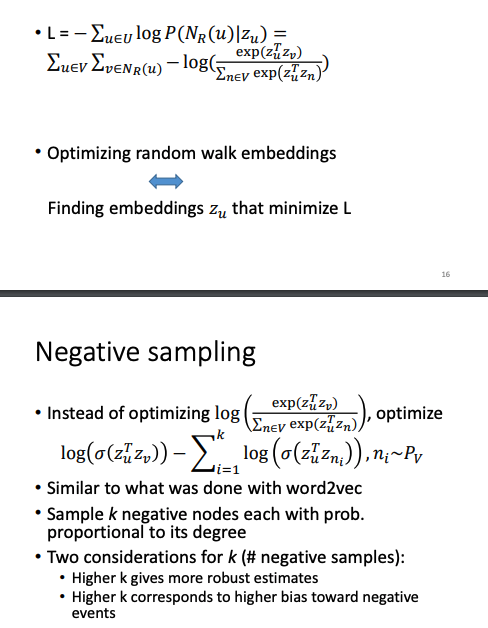

In [ ]:
def Negative_Sampling(b_graph, pred, nru_database, num_negative_nodes):
  L = 0 #loss
  V_size = pred.shape[0]

  Sig = nn.Sigmoid()
  for i in range(V_size):
    Nr_u = nru_database[i] #Nr(u) of node
    Zu = pred[i,:]
    Zv = pred[Nr_u,:]
    dot = torch.matmul(Zu, Zv.T) #perform dot product
    sig_dot = Sig(dot)
    logsig_dot = torch.log(sig_dot)
    s1 = torch.sum(logsig_dot) #computing first part of neg sampling loss

    #now compute second part
    rand_k_neg_node = torch.randint(0,len(b_graph),(num_negative_nodes,))
    neg_nodes = torch.where(b_graph[i, rand_k_neg_node]== 0)
    num_samples = pred[neg_nodes].T
    Zu2 = pred[i,:]
    dot2 = torch.matmul(Zu2, num_samples)
    sig_dot2 = Sig(dot2)
    logsig_dot2 = torch.log(sig_dot2)
    s2 = torch.sum(logsig_dot2)

    L -= (s1 - s2)
    L = L * -1

  return L

#Training Code (Node2Vec)

In [ ]:
def Node2Vec_Train(model,optimizer_t, l_r, epochs, n_walks, return_p, move_out_q, strategy = "Fixed"):

  if optimizer_t == "SGD":
    optimizer = optim.SGD(model.parameters(), lr=l_r)
  elif optimizer_t == "Adam":
    optimizer = torch.optim.Adam(model.parameters(), lr = l_r)

  epoch_count = []
  recall_train = np.zeros(epochs)
  recall_valid = np.zeros(epochs)
  row_num = size_graph.shape[0]
  train_loss = []

  Nru_database = None

  for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    #does random walk for each node and store the explored "neighbourhood" of each node in a dictionary Nru_database
    Nru_database = RW_and_store_nru(row_num, n_walks, return_p, move_out_q) #note: RW_and_store_nru uses function Random_Walk on all nodes (check above)

    num_negative_nodes_to_sample = random.randint(3000,5000) #randomly determine number of negative nodes to sample per epoch for stochastic
    Prediction = model(size_graph.int())

    loss = Negative_Sampling(train_matrix2, Prediction, Nru_database, num_negative_nodes_to_sample)
    train_loss.append(loss.item())
    loss.backward()
    optimizer.step()

    model.eval()
    user_tensor = torch.tensor(train_usersmap)
    movie_tensor = torch.tensor(train_moviesmap)
    Zu = model(user_tensor)
    Zv = model(movie_tensor).T
    dot_emb = torch.matmul(Zu,Zv)
    dot_emb = dot_emb.sum(1) #get the current predictions (for the epoch)

    #Calculate Recall
    user_ids_train = train_set2.values[:,0]
    ratings_train = train_set2.values[:,2]
    user_id_val = val_set2.values[:,0]
    ratings_val = val_set2.values[:,2]

    recall_trainset_cur_epoch = Recall_at_K(zip(user_ids_train,dot_emb, ratings_train))
    recall_valset_cur_epoch = Recall_at_K(zip(user_id_val, dot_emb, ratings_val))
    recall_train[epoch] = recall_trainset_cur_epoch
    recall_valid[epoch] = recall_valset_cur_epoch
    epoch_count.append(epoch)

    print("epoch: ", epoch + 1)
    print("Training Recall: ",recall_trainset_cur_epoch)
    print("Valid Recall: ", recall_valset_cur_epoch)

  plt.figure(1)
  plt.plot(epoch_count, train_loss, label = "Loss")
  plt.title("Loss")
  plt.xlabel("epochs")
  plt.ylabel("loss")
  plt.legend()
  plt.show()

  plt.figure(2)
  plt.plot(epoch_count, recall_train, label = "Recall Train")
  plt.title("Recall of Train Set")
  plt.xlabel("epochs")
  plt.ylabel("Recall")
  plt.legend()
  plt.show()

  plt.figure(3)
  plt.plot(epoch_count, recall_valid)
  plt.title("Recall of Validation Set")
  plt.xlabel("epochs")
  plt.ylabel("Recall")
  plt.show()

  return model

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


epoch:  1
Training Recall:  0.38081448525190353
Valid Recall:  0.11028192440668742
epoch:  2
Training Recall:  0.4069431483745575
Valid Recall:  0.12714206841256884
epoch:  3
Training Recall:  0.41234520375728606
Valid Recall:  0.12714206841256884
epoch:  4
Training Recall:  0.4375782132148743
Valid Recall:  0.1506357060538398
epoch:  5
Training Recall:  0.5446598768234253
Valid Recall:  0.15395245949427286
epoch:  6
Training Recall:  0.5931478291749954
Valid Recall:  0.175787728026534
epoch:  7
Training Recall:  0.6652783721685409
Valid Recall:  0.17412935323383083
epoch:  8
Training Recall:  0.7142915427684784
Valid Recall:  0.1724709784411277
epoch:  9
Training Recall:  0.7535906910896302
Valid Recall:  0.18242122719734657
epoch:  10
Training Recall:  0.8265855431556701
Valid Recall:  0.2935323383084577


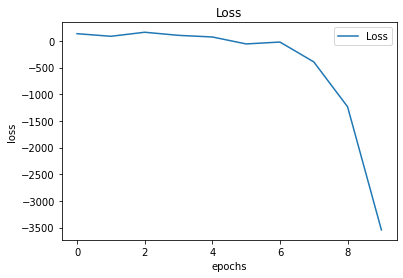

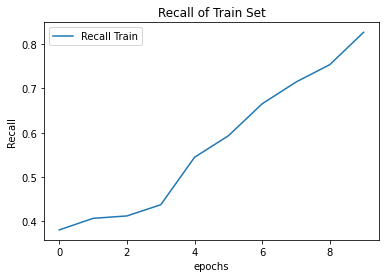

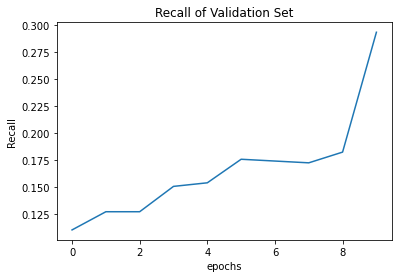

In [ ]:
Node2Vec_model = NodeEmbedding(n_users, n_movies, d, 0.01)
updated_Node2Vec_model = Node2Vec_Train(Node2Vec_model,"SGD",l_r = 0.00015, epochs = 10,n_walks = 4,return_p = 6,move_out_q= 3)

**Comments on Node2Vec Training:**

After tuning multiple models, it was observed that the training recall mainly stagnates around 90% and validation recall stagnates around 30%. Different hyper-parameters (p,q, walk_length, number of negative nodes to sample, type of optimizer...) were tested and the results (training plots) can be seen below.



#Recall on Test Set with Trained Model

In [ ]:
def evaluate(model, testset, usermap, movie_map):
  model.eval()
  user_tensor_t = (usermap).clone().detach()
  movie_tensor_t = (movie_map).clone().detach()
  user_ids_test = testset.values[:,0]
  ratings_test = testset.values[:,2]
  Zu = model(user_tensor_t)
  Zv = model(movie_tensor_t).T
  dot_emb = torch.matmul(Zu,Zv)
  dot_emb = dot_emb.sum(1)

  recall_test = Recall_at_K(zip(user_ids_test, dot_emb, ratings_test))
  print("Test Recall: ", recall_test)

  return recall_test

In [ ]:
test_recall150_0 = evaluate(updated_Node2Vec_model, test_set2, train_usersmap, train_moviesmap)

Test Recall:  0.4957983193277311


#Hyper-parameter Tuning (p,q, walk_length, optimizer, epochs, learning_rate...):

Below are some runs of varying hyper-parameters that I have tried.

Changing ratio of return parameter and move_out parameter

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


epoch:  1
Training Recall:  0.34480305165052416
Valid Recall:  0.09010503027174208
epoch:  2
Training Recall:  0.37110846787691115
Valid Recall:  0.22139303551779854
epoch:  3
Training Recall:  0.4970236361026764
Valid Recall:  0.2078496449523502
epoch:  4
Training Recall:  0.5871923387050628
Valid Recall:  0.2465450547227812
epoch:  5
Training Recall:  0.6675768494606018
Valid Recall:  0.2683803184115472
epoch:  6
Training Recall:  0.7732073068618774
Valid Recall:  0.2716970679969535
epoch:  7
Training Recall:  0.8277987957000732
Valid Recall:  0.2935323383084577
epoch:  8
Training Recall:  0.8645721912384033
Valid Recall:  0.29187396351575456
epoch:  9
Training Recall:  0.9
Valid Recall:  0.29187396351575456
epoch:  10
Training Recall:  0.9
Valid Recall:  0.2902155887230514


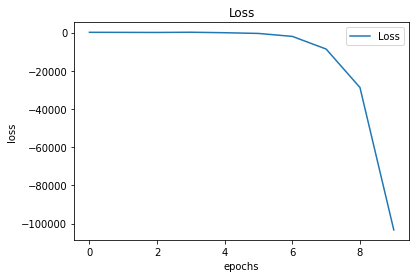

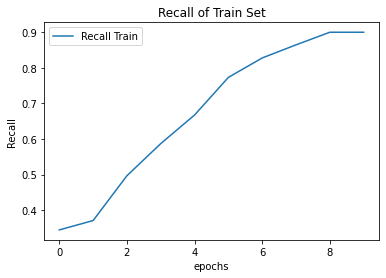

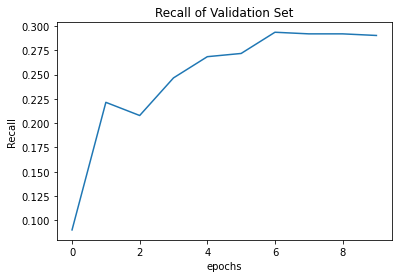

In [ ]:
Node2Vec_model_t1 = NodeEmbedding(n_users, n_movies, d, 0.01)
updated_Node2Vec_model_t1 = Node2Vec_Train(Node2Vec_model_t1,"SGD",l_r = 0.0003, epochs = 10,n_walks = 4,return_p = 10,move_out_q= 2.5)

Changing optimizer to Adam

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


epoch:  1
Training Recall:  0.5202922582626343
Valid Recall:  0.12050857146581014
epoch:  2
Training Recall:  0.5297011286020279
Valid Recall:  0.12880044513278538
epoch:  3
Training Recall:  0.5424800336360931
Valid Recall:  0.13377557198206583
epoch:  4
Training Recall:  0.5522337257862091
Valid Recall:  0.13377557198206583
epoch:  5
Training Recall:  0.5683758199214936
Valid Recall:  0.2683803174230788
epoch:  6
Training Recall:  0.585140523314476
Valid Recall:  0.266721943618844
epoch:  7
Training Recall:  0.5984254747629165
Valid Recall:  0.266721943618844
epoch:  8
Training Recall:  0.6409785926342011
Valid Recall:  0.26506356882614085
epoch:  9
Training Recall:  0.6650629162788391
Valid Recall:  0.26506356882614085
epoch:  10
Training Recall:  0.7080438375473023
Valid Recall:  0.26506356882614085


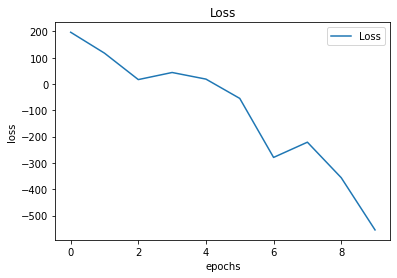

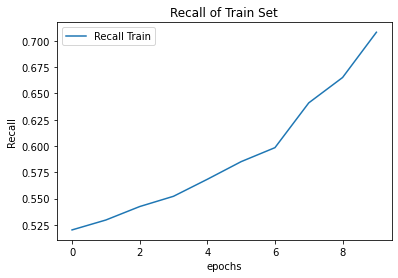

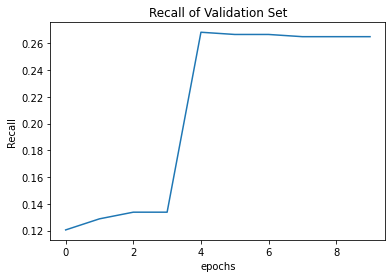

In [ ]:
Node2Vec_model_t2 = NodeEmbedding(n_users, n_movies, d, 0.01)
updated_Node2Vec_model_t2 = Node2Vec_Train(Node2Vec_model_t2,"Adam",l_r = 0.0003, epochs = 10,n_walks = 4,return_p = 6,move_out_q= 3)

Increasing n_walks (or number of nodes sampled in random walk)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


epoch:  1
Training Recall:  0.6019517600536346
Valid Recall:  0.24488668309317696
epoch:  2
Training Recall:  0.5904472827911377
Valid Recall:  0.12714206964815433
epoch:  3
Training Recall:  0.6934101760387421
Valid Recall:  0.16417910447761194
epoch:  4
Training Recall:  0.7754357397556305
Valid Recall:  0.27860696517412936
epoch:  5
Training Recall:  0.8299683928489685
Valid Recall:  0.27860696517412936
epoch:  6
Training Recall:  0.8725839734077454
Valid Recall:  0.27860696517412936
epoch:  7
Training Recall:  0.881155401468277
Valid Recall:  0.27860696517412936
epoch:  8
Training Recall:  0.8891491234302521
Valid Recall:  0.27694859038142616


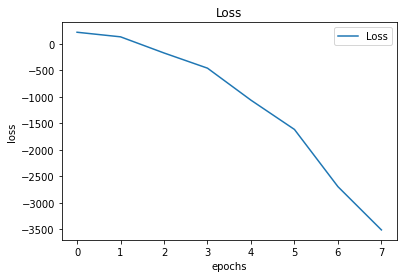

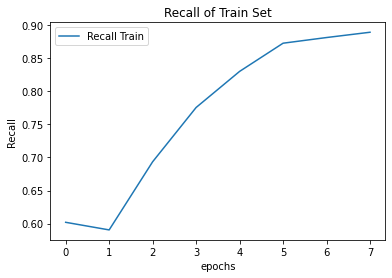

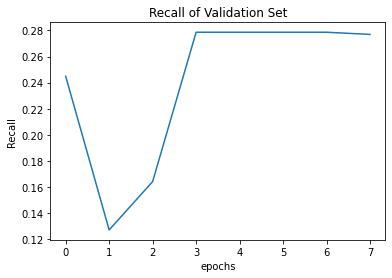

In [ ]:
Node2Vec_model_t5 = NodeEmbedding(n_users, n_movies, d, 0.01)
updated_Node2Vec_model_t5 = Node2Vec_Train(Node2Vec_model_t5,"Adam",l_r = 0.001, epochs = 8,n_walks = 2,return_p = 2,move_out_q= 1)

**Conclusion:**

After testing multiple sets of hyper-parameters, it was found that a learning rate of 0.001 to 0.003 is fairly stable for training. In addition, a p/q ratio of 2 (p = 6, q = 3)in the random walk produces better results than if p/q = 1 (in which case return and move_out become the same). Increasing the number of nodes to visit in the Random_walk seemed to have increased the recall as well. In the end, the best model obtained had recall = 30% for validation set and ~50% for test set. Where as poorer models had validation recall value of ~12%.